# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run150', 'ORACLE.run114', 'ORACLE.run138', 'ORACLE.run126', 'ORACLE.run132', 'ORACLE.run18', 'ORACLE.run144', 'ORACLE.run120'}


{'Wisig_3', 'Wisig_1', 'Wisig_2', 'Wisig_4'}


tensor([[[ 0.2397, -0.3723, -0.7753,  ...,  0.1836, -0.0816,  0.3621],
         [ 0.0102,  0.9844, -0.4029,  ...,  0.0153,  0.2346,  0.8824]],

        [[-0.3773, -0.6392,  0.5554,  ...,  0.4611, -0.3091, -0.0314],
         [ 0.1100, -0.1153,  1.8549,  ...,  0.8226,  0.0524, -0.6235]],

        [[ 0.2983, -0.3245, -0.6333,  ..., -1.4132,  0.1518,  1.4603],
         [-1.2614, -0.1361,  0.5548,  ...,  0.4083,  0.6647,  0.5653]],

        ...,

        [[ 0.7079,  1.1739,  0.9923,  ...,  0.6051, -0.5688, -1.2767],
         [ 0.1634,  0.8169, -0.9258,  ...,  0.2904,  0.5022, -0.3752]],

        [[ 0.3350, -0.1787, -1.2061,  ...,  0.6086,  0.9213, -0.1508],
         [-0.7036,  0.5305, -0.1452,  ..., -0.6366,  0.0614,  1.4853]],

        [[-1.3987, -0.4322,  0.3842,  ..., -1.1466,  0.2281, -0.1441],
         [ 0.1441, -0.9545, -1.0145,  ..., -0.0960,  0.5343,  0.9905]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.3076, train_label_loss: 2.7896, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3816.0620, train_label_loss: 2.7739, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3870.2443, train_label_loss: 1.4908, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3836.7988, train_label_loss: 1.4854, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3858.7964, train_label_loss: 1.5489, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3926.8035, train_label_loss: 1.3661, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3992.5543, train_label_loss: 1.1272, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 4017.9200, train_label_loss: 1.3337, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3939.8696, train_label_loss: 0.8863, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3954.6386, train_label_loss: 0.8676, 


epoch: 1, source_val_acc_label: 0.5385, target_val_acc_label: 0.6248, source_val_label_loss: 1.2080, target_val_label_loss: 5.0024, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.9399, train_label_loss: 0.9417, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3991.2077, train_label_loss: 1.0450, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 4007.8546, train_label_loss: 1.4236, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3924.6999, train_label_loss: 0.6541, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3853.4882, train_label_loss: 1.0006, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3859.8357, train_label_loss: 0.8523, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3831.0522, train_label_loss: 0.6410, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3939.2815, train_label_loss: 0.6085, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 4065.5139, train_label_loss: 1.4054, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 4321.7431, train_label_loss: 0.7864, 


epoch: 2, source_val_acc_label: 0.5875, target_val_acc_label: 0.6441, source_val_label_loss: 1.0770, target_val_label_loss: 6.0537, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.2405, train_label_loss: 1.4242, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 4371.0762, train_label_loss: 0.9959, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 4251.8428, train_label_loss: 0.7192, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 4346.3176, train_label_loss: 0.7908, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 4256.4808, train_label_loss: 1.2422, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 4310.4230, train_label_loss: 0.7878, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 4673.8557, train_label_loss: 0.5284, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 4561.3422, train_label_loss: 0.9635, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 4516.4270, train_label_loss: 0.8921, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 4344.9755, train_label_loss: 0.5820, 


epoch: 3, source_val_acc_label: 0.6066, target_val_acc_label: 0.6647, source_val_label_loss: 1.0484, target_val_label_loss: 7.6526, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.3970, train_label_loss: 0.4613, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 4220.9224, train_label_loss: 0.6308, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 4467.5055, train_label_loss: 0.4520, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 4233.3852, train_label_loss: 0.5634, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 4256.9124, train_label_loss: 0.6446, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 4456.2427, train_label_loss: 0.7153, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 4316.9004, train_label_loss: 0.9938, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 4225.3834, train_label_loss: 0.5285, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 4294.6851, train_label_loss: 0.7523, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 5271.8924, train_label_loss: 0.5489, 


epoch: 4, source_val_acc_label: 0.6191, target_val_acc_label: 0.6755, source_val_label_loss: 1.0675, target_val_label_loss: 8.8588, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 5.0591, train_label_loss: 0.6575, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 5006.4169, train_label_loss: 0.5144, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 5175.6897, train_label_loss: 0.6928, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 5086.9160, train_label_loss: 0.8488, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 5003.0179, train_label_loss: 0.5300, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 5062.6084, train_label_loss: 1.2201, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 5008.2569, train_label_loss: 0.3668, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 5344.2044, train_label_loss: 0.4110, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 5278.6593, train_label_loss: 0.7445, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 5396.6947, train_label_loss: 0.4309, 


epoch: 5, source_val_acc_label: 0.6079, target_val_acc_label: 0.6682, source_val_label_loss: 1.1132, target_val_label_loss: 9.5791, 


epoch: 6, [batch: 1 / 6720], examples_per_second: 5.0739, train_label_loss: 0.4509, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 5048.8059, train_label_loss: 0.4290, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 4944.0355, train_label_loss: 0.6932, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 4956.1255, train_label_loss: 0.7753, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 4958.5988, train_label_loss: 0.5906, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 5079.2609, train_label_loss: 0.6906, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 5030.3264, train_label_loss: 0.4634, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 4951.2808, train_label_loss: 0.8140, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 4958.5105, train_label_loss: 0.5389, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 5059.9640, train_label_loss: 0.4425, 


epoch: 6, source_val_acc_label: 0.6083, target_val_acc_label: 0.6724, source_val_label_loss: 1.1771, target_val_label_loss: 10.8365, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 5.1335, train_label_loss: 0.4754, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 5185.7198, train_label_loss: 0.4027, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 5172.1620, train_label_loss: 0.3512, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 5364.8924, train_label_loss: 0.1745, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 5269.8045, train_label_loss: 0.3608, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 5464.7264, train_label_loss: 0.4497, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 5128.2084, train_label_loss: 0.3418, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 4886.8872, train_label_loss: 0.3623, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 4976.2784, train_label_loss: 0.7387, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 5003.2519, train_label_loss: 0.4596, 


epoch: 7, source_val_acc_label: 0.6012, target_val_acc_label: 0.6776, source_val_label_loss: 1.2362, target_val_label_loss: 11.5019, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 5.2232, train_label_loss: 0.5436, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 4997.5886, train_label_loss: 0.3030, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 5172.5900, train_label_loss: 0.2544, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 5064.1536, train_label_loss: 0.3106, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 4589.0555, train_label_loss: 0.3682, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3840.7801, train_label_loss: 0.6295, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3825.9741, train_label_loss: 0.0963, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3825.3305, train_label_loss: 0.0858, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3855.0163, train_label_loss: 0.1225, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3884.5285, train_label_loss: 0.6580, 


epoch: 8, source_val_acc_label: 0.6038, target_val_acc_label: 0.6739, source_val_label_loss: 1.3333, target_val_label_loss: 13.2179, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.8401, train_label_loss: 0.7435, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3871.0061, train_label_loss: 0.4571, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3917.1360, train_label_loss: 0.1995, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3886.4039, train_label_loss: 0.2992, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3974.3690, train_label_loss: 0.3914, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3953.7869, train_label_loss: 0.2648, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3920.8047, train_label_loss: 0.2345, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3815.1489, train_label_loss: 0.3486, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3835.4561, train_label_loss: 0.1363, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3910.6315, train_label_loss: 0.3438, 


epoch: 9, source_val_acc_label: 0.6045, target_val_acc_label: 0.6799, source_val_label_loss: 1.4145, target_val_label_loss: 14.2658, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 3.8560, train_label_loss: 0.4183, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3903.5604, train_label_loss: 0.5398, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3866.2486, train_label_loss: 0.2809, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3790.9855, train_label_loss: 0.1277, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3812.4708, train_label_loss: 0.2369, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3965.2573, train_label_loss: 0.4156, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3878.3185, train_label_loss: 0.2847, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3857.1834, train_label_loss: 0.0966, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3837.1053, train_label_loss: 0.2585, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3871.6708, train_label_loss: 0.1730, 


epoch: 10, source_val_acc_label: 0.6005, target_val_acc_label: 0.6807, source_val_label_loss: 1.5082, target_val_label_loss: 15.2259, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 3.9161, train_label_loss: 0.2700, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3762.4565, train_label_loss: 0.3390, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3872.2107, train_label_loss: 0.4238, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3980.0752, train_label_loss: 0.1363, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3909.0970, train_label_loss: 0.1100, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3906.7760, train_label_loss: 0.4193, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3918.7678, train_label_loss: 0.1742, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3896.9028, train_label_loss: 0.1936, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3913.6050, train_label_loss: 0.2463, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3929.1491, train_label_loss: 0.3781, 


epoch: 11, source_val_acc_label: 0.6038, target_val_acc_label: 0.6816, source_val_label_loss: 1.5781, target_val_label_loss: 16.6367, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.8784, train_label_loss: 0.1157, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3828.3013, train_label_loss: 0.1634, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3872.1711, train_label_loss: 0.1298, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3932.9906, train_label_loss: 0.4456, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3994.0492, train_label_loss: 0.0567, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 4272.5820, train_label_loss: 0.2655, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 4181.0830, train_label_loss: 0.3024, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 4137.5284, train_label_loss: 0.4612, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 4167.9952, train_label_loss: 0.5408, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 4497.5553, train_label_loss: 0.1568, 


epoch: 12, source_val_acc_label: 0.5966, target_val_acc_label: 0.6741, source_val_label_loss: 1.7064, target_val_label_loss: 17.9501, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 5.0999, train_label_loss: 0.2262, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3924.8086, train_label_loss: 0.2614, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3966.2344, train_label_loss: 0.0273, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3945.9333, train_label_loss: 0.3147, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3957.5709, train_label_loss: 0.4831, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3882.1089, train_label_loss: 0.1392, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3943.6320, train_label_loss: 0.1059, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3918.0654, train_label_loss: 0.2657, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3843.7569, train_label_loss: 0.3375, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3913.3550, train_label_loss: 0.5105, 


epoch: 13, source_val_acc_label: 0.5966, target_val_acc_label: 0.6831, source_val_label_loss: 1.7488, target_val_label_loss: 18.4955, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.8835, train_label_loss: 0.3279, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3927.6427, train_label_loss: 0.1046, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3937.3794, train_label_loss: 0.3204, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3918.2899, train_label_loss: 0.1511, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3939.5179, train_label_loss: 0.5947, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3934.7209, train_label_loss: 0.3432, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3842.5736, train_label_loss: 0.0407, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3909.0223, train_label_loss: 0.0717, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3925.5836, train_label_loss: 0.0180, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3893.2652, train_label_loss: 0.6013, 


epoch: 14, source_val_acc_label: 0.5963, target_val_acc_label: 0.6831, source_val_label_loss: 1.8102, target_val_label_loss: 19.3167, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.8379, train_label_loss: 0.1429, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3995.4201, train_label_loss: 0.2028, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 4005.5404, train_label_loss: 0.0318, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 4007.5093, train_label_loss: 0.3128, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3892.0154, train_label_loss: 0.2158, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3917.2081, train_label_loss: 0.0441, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3941.6537, train_label_loss: 0.4059, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3999.8796, train_label_loss: 0.0469, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 4097.4202, train_label_loss: 0.0839, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 4103.8916, train_label_loss: 0.1250, 


epoch: 15, source_val_acc_label: 0.5924, target_val_acc_label: 0.6838, source_val_label_loss: 1.8946, target_val_label_loss: 20.0345, 


New best


epoch: 16, [batch: 1 / 6720], examples_per_second: 3.9008, train_label_loss: 0.0461, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3924.2675, train_label_loss: 0.2069, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3971.1963, train_label_loss: 0.0725, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 4094.5943, train_label_loss: 0.0901, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 4070.8017, train_label_loss: 0.1630, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 4003.3514, train_label_loss: 0.2066, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 4113.0483, train_label_loss: 0.0786, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 4065.4565, train_label_loss: 0.0474, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 4124.5735, train_label_loss: 0.3010, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 4072.1129, train_label_loss: 0.0090, 


epoch: 16, source_val_acc_label: 0.5913, target_val_acc_label: 0.6811, source_val_label_loss: 1.9489, target_val_label_loss: 20.7454, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 3.9165, train_label_loss: 0.0827, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3988.5630, train_label_loss: 0.0134, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 4188.5841, train_label_loss: 0.4223, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 4274.3674, train_label_loss: 0.2154, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 4208.2824, train_label_loss: 0.0062, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 4553.1022, train_label_loss: 0.0764, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 4366.4536, train_label_loss: 0.2487, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 4905.3202, train_label_loss: 0.0308, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 5150.4119, train_label_loss: 0.0784, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 4105.2637, train_label_loss: 0.5965, 


epoch: 17, source_val_acc_label: 0.5912, target_val_acc_label: 0.6873, source_val_label_loss: 2.0015, target_val_label_loss: 21.9832, 


New best


epoch: 18, [batch: 1 / 6720], examples_per_second: 3.8705, train_label_loss: 0.1033, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 3932.7984, train_label_loss: 0.2541, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 4026.9071, train_label_loss: 0.0240, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 4007.5681, train_label_loss: 0.1724, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 4053.7959, train_label_loss: 0.1478, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 4056.0028, train_label_loss: 0.1306, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3964.9976, train_label_loss: 0.2559, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 4021.4570, train_label_loss: 0.2498, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 3828.9568, train_label_loss: 0.3114, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3859.0084, train_label_loss: 0.1931, 


epoch: 18, source_val_acc_label: 0.5962, target_val_acc_label: 0.6913, source_val_label_loss: 2.0453, target_val_label_loss: 22.6196, 


New best


epoch: 19, [batch: 1 / 6720], examples_per_second: 3.8613, train_label_loss: 0.4706, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 3962.5622, train_label_loss: 0.3733, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 3952.4411, train_label_loss: 0.1046, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 3995.4821, train_label_loss: 0.2992, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 4049.2952, train_label_loss: 0.0622, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 3940.3660, train_label_loss: 0.4462, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 3938.7966, train_label_loss: 0.1987, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 3950.3194, train_label_loss: 0.0293, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 3914.6409, train_label_loss: 0.1774, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 3864.6443, train_label_loss: 0.2167, 


epoch: 19, source_val_acc_label: 0.5959, target_val_acc_label: 0.6897, source_val_label_loss: 2.1361, target_val_label_loss: 23.1453, 


epoch: 20, [batch: 1 / 6720], examples_per_second: 3.8036, train_label_loss: 0.2740, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 3915.3502, train_label_loss: 0.0187, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 3847.3640, train_label_loss: 0.1127, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 3876.9766, train_label_loss: 0.3737, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 3810.1787, train_label_loss: 0.0575, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 3899.2244, train_label_loss: 0.1524, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 3935.4966, train_label_loss: 0.0840, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 4013.2224, train_label_loss: 0.2428, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 4010.2360, train_label_loss: 0.0227, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 4002.4209, train_label_loss: 0.0230, 


epoch: 20, source_val_acc_label: 0.5921, target_val_acc_label: 0.6824, source_val_label_loss: 2.1786, target_val_label_loss: 23.8127, 


epoch: 21, [batch: 1 / 6720], examples_per_second: 3.8709, train_label_loss: 0.0326, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 3918.5711, train_label_loss: 0.1217, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 3874.3421, train_label_loss: 0.1336, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 3883.8675, train_label_loss: 0.2183, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 3845.8849, train_label_loss: 0.1464, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 4000.1859, train_label_loss: 0.0847, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 3998.3074, train_label_loss: 0.0890, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 3992.6461, train_label_loss: 0.0435, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 4024.1365, train_label_loss: 0.0358, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 4196.1677, train_label_loss: 0.1517, 


epoch: 21, source_val_acc_label: 0.5946, target_val_acc_label: 0.6886, source_val_label_loss: 2.1985, target_val_label_loss: 24.0878, 


epoch: 22, [batch: 1 / 6720], examples_per_second: 4.3166, train_label_loss: 0.0308, 


epoch: 22, [batch: 672 / 6720], examples_per_second: 4819.4673, train_label_loss: 0.2776, 


epoch: 22, [batch: 1344 / 6720], examples_per_second: 4660.8619, train_label_loss: 0.0727, 


epoch: 22, [batch: 2016 / 6720], examples_per_second: 5072.5852, train_label_loss: 0.1657, 


epoch: 22, [batch: 2688 / 6720], examples_per_second: 4779.6387, train_label_loss: 0.0847, 


epoch: 22, [batch: 3360 / 6720], examples_per_second: 3937.4899, train_label_loss: 0.0437, 


epoch: 22, [batch: 4032 / 6720], examples_per_second: 3859.9161, train_label_loss: 0.3689, 


epoch: 22, [batch: 4704 / 6720], examples_per_second: 3831.1826, train_label_loss: 0.1283, 


epoch: 22, [batch: 5376 / 6720], examples_per_second: 3938.9409, train_label_loss: 0.0020, 


epoch: 22, [batch: 6048 / 6720], examples_per_second: 3935.0449, train_label_loss: 0.0068, 


epoch: 22, source_val_acc_label: 0.5979, target_val_acc_label: 0.6909, source_val_label_loss: 2.2243, target_val_label_loss: 25.1502, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

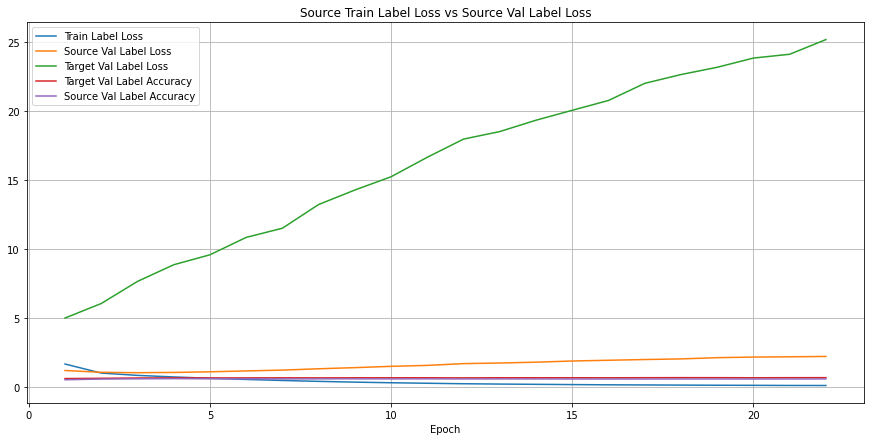

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

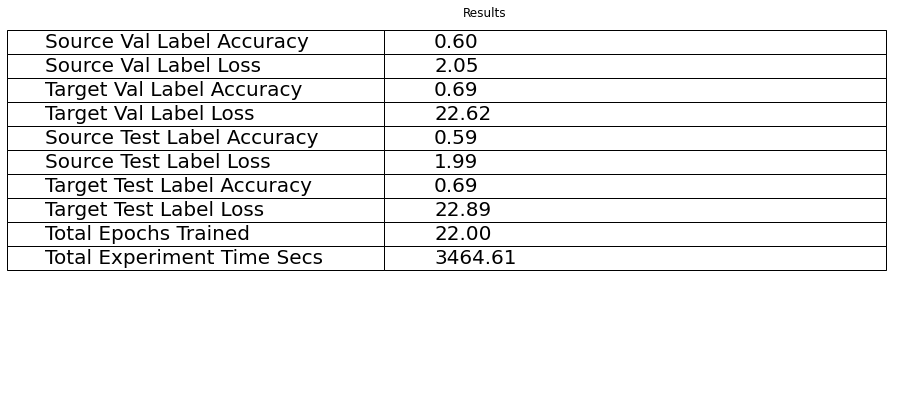

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

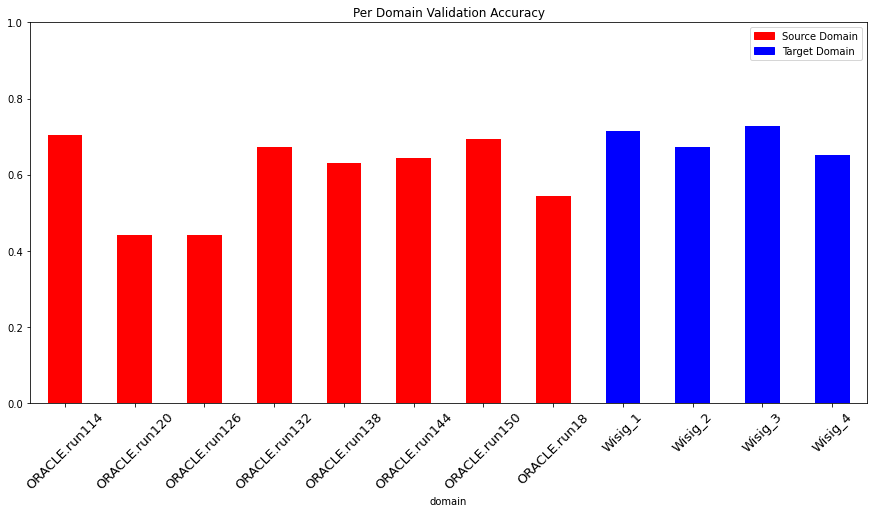

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.5931640625 Target Test Label Accuracy: 0.68916015625
Source Val Label Accuracy: 0.5961588541666667 Target Val Label Accuracy: 0.6913441145281018


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}